---
title: Provided Model Tuning
format: html
---


In [25]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

train_file_names = os.listdir("train/")
train_file_names.sort()

train_files = []
for file in train_file_names:
    train_files.append(pd.read_csv(f"train/{file}", sep=";"))

test_file_names = os.listdir("test/")
test_file_names.sort()

test_files = []
for file in test_file_names:
    test_files.append(pd.read_csv(f"test/{file}", sep=";"))

test_files[0].head()

,Value1,Labels
0,20.801402,0
1,26.800208,0
2,33.154527,0
3,39.189824,0
4,40.631321,0


## Student EDA
Use this cell to explore the signal (e.g., plot, summary stats).


In [26]:
# STUDENT EDA
try:
    df = test_files[0]
    print(df.head())
except Exception as e:
    print('EDA note: run the original data-loading cells first (the ones that populate train_files/test_files).')
    df.info()
    df.describe()

    df.plot(x='time')

      Value1  Labels
0  20.801402       0
1  26.800208       0
2  33.154527       0
3  39.189824       0
4  40.631321       0


# **The Model**

In [12]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

warnings.filterwarnings(
    "ignore",
    message="Determinant has increased; this should not happen"
)

@njit
def create_windows_numba(series, window_size):
    n_windows = len(series) - window_size + 1
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        windows[i, :] = series[i : i + window_size]
    return windows

@njit
def normalize_scores(scores):
    mn = np.min(scores)
    mx = np.max(scores)
    return (scores - mn) / (mx - mn + 1e-8)


class AnomalyDetectionModel:
    def __init__(self, window_size=30, contamination=0.01):
        self.window_size = window_size
        self.offset = window_size // 2
        self.contamination = contamination

        self.scaler = StandardScaler()
        self.models = {
            'IsolationForest': IsolationForest(contamination=contamination, random_state=42),
            'OneClassSVM': OneClassSVM(kernel='rbf', gamma='scale', nu=contamination),
            'EllipticEnvelope': EllipticEnvelope(contamination=contamination,
                                                 support_fraction=0.75,
                                                 random_state=42),
        }

        self.use_lof = True
        self.lof_model = LocalOutlierFactor(n_neighbors=20,
                                            contamination=contamination,
                                            novelty=True)
        self.full_anomaly_mask = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        self.train_windows = self._create_windows(X)
        self.scaled_train_windows = self.scaler.fit_transform(self.train_windows)
        for model in self.models.values():
            model.fit(self.scaled_train_windows)
        if self.use_lof:
            self.lof_model.fit(self.scaled_train_windows)

    def predict(self, X: np.ndarray):

        test_windows = self._create_windows(X)
        scaled = self.scaler.transform(test_windows)


        all_scores = []
        for model in self.models.values():
            if hasattr(model, "decision_function"):
                s = model.decision_function(scaled)
                all_scores.append(normalize_scores(s))
            else:
                preds = model.predict(scaled)
                all_scores.append(np.where(preds == -1, 0.0, 1.0))

        if self.use_lof:
            lof_s = self.lof_model.decision_function(scaled)
            all_scores.append(normalize_scores(lof_s))

        avg_scores = np.mean(np.stack(all_scores, axis=0), axis=0)
        thresh = np.percentile(avg_scores, self.contamination * 100)
        mask = np.zeros(len(X), dtype=int)
        mask[self.offset : self.offset + len(avg_scores)] = (avg_scores <= thresh).astype(int)
        self.full_anomaly_mask = mask
        idx = np.argmin(avg_scores)
        return idx + self.offset
    def _create_windows(self, series: np.ndarray):
        return create_windows_numba(series, self.window_size)

In [6]:
# hybrid_anomaly_detector.py
import warnings
import numpy as np
import pandas as pd
from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import ParameterGrid, train_test_split
import itertools
import math
import random

warnings.filterwarnings(
    "ignore",
    message="Determinant has increased; this should not happen"
)

# -------------------------
# Low-level utilities
# -------------------------
@njit
def create_windows_numba(series, window_size):
    n_windows = len(series) - window_size + 1
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        windows[i, :] = series[i : i + window_size]
    return windows

@njit
def normalize_scores_numba(scores):
    mn = np.min(scores)
    mx = np.max(scores)
    out = (scores - mn) / (mx - mn + 1e-8)
    return out

def extract_ranges_from_mask(mask):
    """
    Convert binary mask (1 anomaly, 0 normal) into list of (start, end) ranges [start, end)
    """
    ranges = []
    n = len(mask)
    i = 0
    while i < n:
        if mask[i] == 1:
            start = i
            j = i + 1
            while j < n and mask[j] == 1:
                j += 1
            ranges.append((start, j))
            i = j
        else:
            i += 1
    return ranges

def extract_true_ranges(labels):
    """Assumes labels is 0/1 vector. Returns list of (start,end)."""
    return extract_ranges_from_mask(labels.astype(int))

# -------------------------
# Evaluator
# -------------------------
class AnomalyEvaluator:
    def __init__(self):
        pass

    def evaluate_pointwise(self, true_labels, pred_labels):
        """Return dict of standard point-wise metrics."""
        metrics = {}
        metrics['precision'] = precision_score(true_labels, pred_labels, zero_division=0)
        metrics['recall'] = recall_score(true_labels, pred_labels, zero_division=0)
        metrics['f1'] = f1_score(true_labels, pred_labels, zero_division=0)
        metrics['accuracy'] = accuracy_score(true_labels, pred_labels)
        # AUC only if both classes present
        try:
            if len(np.unique(true_labels)) == 2:
                metrics['roc_auc'] = roc_auc_score(true_labels, pred_labels)
            else:
                metrics['roc_auc'] = np.nan
        except Exception:
            metrics['roc_auc'] = np.nan
        return metrics

    def evaluate_ranges(self, true_ranges, pred_ranges, signal_length=None):
        """
        Range-level evaluation:
          - precision = #pred_ranges that overlap any true_range / #pred_ranges
          - recall = #true_ranges detected / #true_ranges
          - f1 from precision & recall
          - avg_overlap_ratio: average (over matched predicted ranges) of intersection/union
          - avg_delay: average (pred_start - true_start) for matched ranges (if pred_start >= true_start),
                       negative if predicted earlier.
        """
        if signal_length is None:
            # if no ranges and can't determine, set to 0
            signal_length = 0

        def overlap(a, b):
            # a and b are (s,e)
            s = max(a[0], b[0])
            e = min(a[1], b[1])
            return max(0, e - s)

        matched_pred = 0
        matched_true = 0
        overlap_ratios = []
        delays = []

        true_matched_flags = [False] * len(true_ranges)

        for p in pred_ranges:
            # find best overlapping true range (largest overlap)
            best_overlap = 0
            best_idx = -1
            for i, t in enumerate(true_ranges):
                ov = overlap(p, t)
                if ov > best_overlap:
                    best_overlap = ov
                    best_idx = i
            if best_overlap > 0:
                matched_pred += 1
                true_t = true_ranges[best_idx]
                if not true_matched_flags[best_idx]:
                    matched_true += 1
                    true_matched_flags[best_idx] = True

                # compute union
                union_len = (max(p[1], true_t[1]) - min(p[0], true_t[0]))
                overlap_ratios.append(best_overlap / (union_len + 1e-8))

                # detection delay: predicted start - true start
                delays.append(p[0] - true_t[0])

        n_pred = len(pred_ranges)
        n_true = len(true_ranges)

        precision = matched_pred / (n_pred + 1e-8) if n_pred > 0 else 0.0
        recall = matched_true / (n_true + 1e-8) if n_true > 0 else 0.0
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        avg_overlap = np.mean(overlap_ratios) if len(overlap_ratios) > 0 else 0.0
        avg_delay = np.mean(delays) if len(delays) > 0 else np.nan

        return {
            "range_precision": precision,
            "range_recall": recall,
            "range_f1": f1,
            "avg_overlap_ratio": float(avg_overlap),
            "avg_delay": float(avg_delay) if not math.isnan(avg_delay) else np.nan,
            "n_pred_ranges": n_pred,
            "n_true_ranges": n_true
        }

# -------------------------
# Hybrid Anomaly Detector
# -------------------------
class HybridAnomalyDetector:
    """
    Hybrid anomaly detector with reproducibility and a tuning method (requires labelled validation set).
    - window_size: sliding window length used to transform time series -> windows
    - contamination: expected proportion of anomalies (used as thresholding fallback)
    - models: default ensemble of IsolationForest, OneClassSVM, EllipticEnvelope, LocalOutlierFactor
    - random_state: global random seed for reproducibility
    """

    def __init__(self, window_size=30, contamination=0.01, random_state=42, use_lof=True):
        self.window_size = int(window_size)
        self.offset = self.window_size // 2
        self.contamination = contamination
        self.random_state = int(random_state)
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        self.scaler = StandardScaler()

        # instantiate default models with a place to tune their params
        self.models = {
            'IsolationForest': IsolationForest(contamination=contamination, random_state=self.random_state),
            'OneClassSVM': OneClassSVM(kernel='rbf', gamma='scale', nu=contamination),
            'EllipticEnvelope': EllipticEnvelope(contamination=contamination, support_fraction=0.75, random_state=self.random_state),
        }

        self.use_lof = use_lof
        if self.use_lof:
            self.models['LocalOutlierFactor'] = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)

        # placeholders filled after fit:
        self.train_windows = None
        self.scaled_train_windows = None
        self.fitted_models = {}
        self.full_anomaly_mask = None
        self.predicted_labels = None
        self.ranges = None
        self.scores = None  # ensemble scores per window

    # ---------- window helpers ----------
    def _create_windows(self, series: np.ndarray):
        if len(series) < self.window_size:
            raise ValueError("Series shorter than window_size.")
        return create_windows_numba(series.astype(np.float32), self.window_size)

    # ---------- fitting ----------
    def fit(self, X: np.ndarray):
        """
        Fit all submodels on X (1D numpy array). No labels required.
        """
        np.random.seed(self.random_state)
        self.train_windows = self._create_windows(X)
        self.scaled_train_windows = self.scaler.fit_transform(self.train_windows)
        self.fitted_models = {}
        # fit a fresh copy of each model
        for name, model in self.models.items():
            # clone by re-instantiating with same parameters to avoid state sharing
            params = model.get_params()
            cls = model.__class__
            params['random_state'] = self.random_state if 'random_state' in params else params.get('random_state', None)
            new_model = cls(**{k: v for k, v in params.items() if v is not None})
            new_model.set_params(**{k: v for k, v in model.get_params().items() if k not in ['random_state']})
            # Fit
            try:
                new_model.fit(self.scaled_train_windows)
            except Exception:
                # some models may require different interfaces; fallback to original fit
                model.fit(self.scaled_train_windows)
                new_model = model
            self.fitted_models[name] = new_model

    # ---------- score aggregation ----------
    def _get_model_scores_on_windows(self, windows_scaled):
        """
        Return dict of arrays: model_name -> normalized score array (higher -> more normal)
        We'll normalize so that higher = more normal; we'll invert later to have anomaly score.
        """
        scores = {}
        for name, model in self.fitted_models.items():
            # prefer decision_function, then score_samples, else predict
            if hasattr(model, "decision_function"):
                s = model.decision_function(windows_scaled)
                s = np.asarray(s, dtype=np.float32)
                s = normalize_scores_numba(s)  # normalized 0..1
                scores[name] = s
            elif hasattr(model, "score_samples"):
                s = model.score_samples(windows_scaled)
                s = np.asarray(s, dtype=np.float32)
                s = normalize_scores_numba(s)
                scores[name] = s
            else:
                # predict: returns 1 (inlier) or -1 (outlier)
                p = model.predict(windows_scaled)
                s = np.where(np.asarray(p) == -1, 0.0, 1.0).astype(np.float32)
                scores[name] = s
        return scores

    def predict_scores(self, X: np.ndarray):
        """
        Produce ensemble anomaly scores for each sliding window and the aligned point-wise anomaly score.
        Returns:
          - avg_anomaly_scores_windows: np.array of length n_windows where higher = more anomalous
          - aligned_point_scores: np.array length len(X) with 0..1 scores aligned to original samples
        """
        test_windows = self._create_windows(X)
        scaled = self.scaler.transform(test_windows)
        model_scores = self._get_model_scores_on_windows(scaled)

        # combine: convert 'normal' score->anomaly score = 1 - normalized_normal_score
        stack = []
        for v in model_scores.values():
            stack.append(1.0 - v)
        stacked = np.vstack(stack)  # shape (n_models, n_windows)
        avg_scores = np.mean(stacked, axis=0)

        # normalize avg_scores 0..1
        avg_scores = (avg_scores - avg_scores.min()) / (avg_scores.max() - avg_scores.min() + 1e-8)

        # align to original points by placing each window's score at its center index
        aligned = np.zeros(len(X), dtype=np.float32)
        n_windows = len(avg_scores)
        start = self.offset
        aligned[start : start + n_windows] = avg_scores

        return avg_scores, aligned

    def detect_anomalies(self, X: np.ndarray, top_k_ranges=None):
        """
        Run detection and produce:
         - predicted_labels (0/1 array)
         - ranges list of (start,end) for contiguous anomaly segments
         - scores aligned with original series
         - returns peak_index (index of most anomalous point)
        Optional: top_k_ranges - keep only top_k ranges by average score magnitude (descending)
        """
        avg_scores_windows, aligned = self.predict_scores(X)
        self.scores = aligned

        # threshold: percentile based on contamination
        thresh = np.percentile(avg_scores_windows, 100 * (1 - self.contamination))  # high anomaly = high score
        # produce mask on aligned
        mask = np.zeros(len(X), dtype=int)
        mask[self.offset : self.offset + len(avg_scores_windows)] = (avg_scores_windows >= thresh).astype(int)
        self.full_anomaly_mask = mask

        # extract ranges
        ranges = extract_ranges_from_mask(mask)
        if top_k_ranges is not None and len(ranges) > top_k_ranges:
            # rank by avg anomaly score within range
            range_scores = [np.mean(aligned[s:e]) for s, e in ranges]
            ranked = [r for _, r in sorted(zip(range_scores, ranges), key=lambda x: x[0], reverse=True)]
            ranges = ranked[:top_k_ranges]
            # rebuild mask and predicted_labels
            new_mask = np.zeros_like(mask)
            for s, e in ranges:
                new_mask[s:e] = 1
            mask = new_mask

        self.ranges = ranges
        self.predicted_labels = mask
        # return index of most anomalous window center
        peak_window_idx = int(np.argmax(avg_scores_windows))
        peak_index = peak_window_idx + self.offset
        return peak_index

    # ---------- simple per-model hyperparameter tuning using labeled validation set ----------
    def tune(self, X_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, param_grids: dict = None, max_iters_per_model=None):
        """
        Tune each model's parameters using a labeled validation set.
        - X_train: 1D numpy array used to fit scaler & models baseline
        - X_val: 1D numpy array used for evaluating model behaviour
        - y_val: 0/1 vector of same length as X_val with ground-truth labels
        - param_grids: dict: model_name -> param_grid dict (as in sklearn). Example:
            {
              'IsolationForest': {'n_estimators': [100,200], 'max_samples': [0.5, 1.0]},
              'OneClassSVM': {'nu': [0.005, 0.01, 0.05], 'gamma':['scale','auto']},
            }
        - If param_grids is None, uses reasonable defaults.
        Returns best_params dict.
        """
        # default grids
        if param_grids is None:
            param_grids = {
                'IsolationForest': {'n_estimators': [100, 200], 'max_samples': [0.5, 1.0], 'contamination': [self.contamination]},
                'OneClassSVM': {'nu': [max(1e-4, self.contamination/2), self.contamination, min(0.5, max(0.1, self.contamination*5))], 'gamma': ['scale', 'auto']},
                'EllipticEnvelope': {'support_fraction': [0.6, 0.75, 1.0], 'contamination': [self.contamination]},
                'LocalOutlierFactor': {'n_neighbors': [10, 20, 35], 'contamination': [self.contamination]}
            }

        # prepare training
        self.fit(X_train)  # initial fit with default params so scaler available
        best_params = {}

        X_val_windows = self._create_windows(X_val)
        scaled_val_windows = self.scaler.transform(X_val_windows)

        # We'll iterate over parameter grid per model, fit on scaled train windows and evaluate using F1 on validation series
        for model_name, model in list(self.models.items()):
            grid = param_grids.get(model_name, {})
            if len(grid) == 0:
                best_params[model_name] = model.get_params()
                continue

            best_f1 = -1.0
            best_param = model.get_params()

            # create iterable of parameter combos
            combos = list(ParameterGrid(grid))
            if max_iters_per_model is not None and len(combos) > max_iters_per_model:
                combos = random.sample(combos, max_iters_per_model)

            for params in combos:
                # instantiate fresh model with these params
                cls = model.__class__
                # ensure random_state consistency if supported
                if 'random_state' in cls().get_params().keys():
                    params_local = {**params, 'random_state': self.random_state}
                else:
                    params_local = params

                try:
                    candidate = cls(**params_local)
                except Exception:
                    # fallback: try without random_state
                    candidate = cls(**{k: v for k, v in params.items()})

                # fit candidate on scaled_train_windows
                try:
                    candidate.fit(self.scaled_train_windows)
                except Exception:
                    # some models (LOF with novelty=True OK). Try continue
                    continue

                # compute scores on validation windows
                if hasattr(candidate, "decision_function"):
                    s = candidate.decision_function(scaled_val_windows)
                    s = normalize_scores_numba(np.asarray(s, dtype=np.float32))
                    anom_scores = 1.0 - s
                elif hasattr(candidate, "score_samples"):
                    s = candidate.score_samples(scaled_val_windows)
                    s = normalize_scores_numba(np.asarray(s, dtype=np.float32))
                    anom_scores = 1.0 - s
                else:
                    p = candidate.predict(scaled_val_windows)
                    anom_scores = np.where(np.asarray(p) == -1, 1.0, 0.0)

                # align to original X_val
                aligned = np.zeros(len(X_val), dtype=np.float32)
                aligned[self.offset : self.offset + len(anom_scores)] = anom_scores

                # threshold using contamination percentile
                thr = np.percentile(anom_scores, 100 * (1 - self.contamination))
                mask = np.zeros(len(X_val), dtype=int)
                mask[self.offset : self.offset + len(anom_scores)] = (anom_scores >= thr).astype(int)

                # compute F1 vs y_val
                f1 = f1_score(y_val, mask, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_param = params

            best_params[model_name] = best_param

            # Update the model in self.models with best params and refit on full train
            try:
                cls = model.__class__
                if 'random_state' in model.get_params().keys():
                    final_params = {**best_param, 'random_state': self.random_state}
                else:
                    final_params = best_param
                self.models[model_name] = cls(**final_params)
            except Exception:
                # if instantiation failed, keep original
                pass

            # re-fit all models at the end of loop
            self.fit(X_train)

        return best_params

# -------------------------
# Example usage with evaluator + test loop the user provided
# -------------------------
if __name__ == "__main__":
    # Example showing how to wire up with the evaluation loop you gave:
    import os
    from glob import glob

    # create detector and evaluator
    detector = HybridAnomalyDetector(window_size=30, contamination=0.01, random_state=42, use_lof=True)
    evaluator = AnomalyEvaluator()

    # test file names (user provided)
    test_file_names = [
        "01.csv", "02.csv", "03.csv", "04.csv", "05.csv",
        "06.csv", "07.csv", "08.csv", "09.csv", "10.csv"
    ]

    point_metrics_list = []
    range_metrics_list = []

    def simple_top_k_refine(df, detector, k=10):
        """Refine detected ranges to top-k by amplitude / avg anomaly score"""
        anomalies = detector.ranges or []
        if len(anomalies) == 0:
            return []
        scores = []
        for a in anomalies:
            s = np.mean(np.abs(df['Value1'].iloc[a[0]:a[1]].to_numpy() - df['Value1'].mean()))
            scores.append(s)
        if len(anomalies) > k:
            top_10 = [x for _, x in sorted(zip(scores, anomalies), reverse=True)[:k]]
        else:
            top_10 = anomalies
        return top_10

    for file in test_file_names:
        path = os.path.join("test", file)
        if not os.path.exists(path):
            print(f"Warning: {path} not found; skipping in example run.")
            continue

        df = pd.read_csv(path, sep=";")
        series = df['Value1'].to_numpy()

        # Fit using the file itself for unsupervised case (or you can provide historical normal series)
        try:
            detector.fit(series)
        except Exception as e:
            print("Fit failed:", e)
            continue

        # Detect anomalies normally first
        detector.detect_anomalies(series)

        # Refine to top 10 ranges by magnitude
        anomalies = detector.ranges or []
        top_10 = simple_top_k_refine(df, detector, k=10)

        # Update detector output
        detector.ranges = top_10
        predicted_labels = np.zeros(len(df), dtype=int)
        for start, end in top_10:
            predicted_labels[start:end] = 1
        detector.predicted_labels = predicted_labels

        # Evaluate
        true_labels = df['Labels'].to_numpy()
        true_ranges = extract_true_ranges(true_labels)

        point_metrics = evaluator.evaluate_pointwise(true_labels, detector.predicted_labels)
        range_metrics = evaluator.evaluate_ranges(true_ranges, detector.ranges)

        point_metrics_list.append(point_metrics)
        range_metrics_list.append(range_metrics)

        print(f"\nFile: {file}")
        print("Point-wise metrics:", {k: f"{v:.4f}" for k, v in point_metrics.items()})
        print("Range-level metrics:", {k: f"{v:.4f}" for k, v in range_metrics.items()})
        print("Top 10 anomaly ranges:", top_10)


File: 01.csv
Point-wise metrics: {'precision': '1.0000', 'recall': '0.0213', 'f1': '0.0417', 'accuracy': '0.9127', 'roc_auc': '0.5107'}
Range-level metrics: {'range_precision': '1.0000', 'range_recall': '0.7000', 'range_f1': '0.8235', 'avg_overlap_ratio': '0.0362', 'avg_delay': '47.6000', 'n_pred_ranges': '10.0000', 'n_true_ranges': '10.0000'}
Top 10 anomaly ranges: [(8737, 8738), (8636, 8641), (2943, 2945), (2870, 2871), (7104, 7106), (7099, 7103), (7703, 7704), (6244, 6245), (6003, 6004), (5606, 5607)]

File: 02.csv
Point-wise metrics: {'precision': '1.0000', 'recall': '0.0300', 'f1': '0.0582', 'accuracy': '0.8965', 'roc_auc': '0.5150'}
Range-level metrics: {'range_precision': '1.0000', 'range_recall': '0.4000', 'range_f1': '0.5714', 'avg_overlap_ratio': '0.0307', 'avg_delay': '52.0000', 'n_pred_ranges': '10.0000', 'n_true_ranges': '10.0000'}
Top 10 anomaly ranges: [(9154, 9155), (3552, 3557), (3495, 3498), (2312, 2316), (2217, 2221), (6891, 6893), (6898, 6900), (9195, 9198), (6883,

## Explanation

This pipeline works on the idea that:

        1) it builds upon sliding windows
        2) gathers normalised anomaly scores from each sub-model and uses them
        3) averages the anomaly scores
        4) computes a binary mask by thresholding at the 1st percentile so that it can compare outputs
        5) stores self.full_anomaly_mask (same length as the placeholder value)
        6) returns the single index of the lowest‐score window center which closes the loop on the sliding window idea


## **STUDENT TODO — Implement your anomaly detector**
Implement Machine Learning/ Statistical models or both. Use the test_files (test series) to train your models and list of anomaly index range for example Anomaly 1:   2001-2005
Anomaly 2:   2010-2012


**Constraints**

- Keep it efficient; we will run this over 10 datasets and additional novel datasets in class.


# **Importing Libraries**
In this section, we import all required libraries.
The anomaly detection system relies on several classical machine learning models (Isolation Forest, One-Class SVM, etc.) and combines them into a hybrid ensemble.
We’ll also set warning filters and random seeds for reproducibility.

In [65]:
# Suppress unnecessary warnings for cleaner output
import warnings
warnings.filterwarnings(
    "ignore",
    message="Determinant has increased; this should not happen"
)

# Core libraries
import numpy as np
import pandas as pd
import random
import math
import itertools

# Machine learning models
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
)
from sklearn.model_selection import ParameterGrid

# Performance optimization
from numba import njit

# **Normalization of scores functions**

These helper functions handle window creation (for temporal context) and normalization of model scores.
The use of numba’s @njit decorator accelerates numerical operations by compiling them to machine code.

In [66]:
@njit
def create_windows_numba(series, window_size):
    n_windows = len(series) - window_size + 1
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        windows[i, :] = series[i : i + window_size]
    return windows

@njit
def normalize_scores_numba(scores):
    mn = np.min(scores)
    mx = np.max(scores)
    out = (scores - mn) / (mx - mn + 1e-8)
    return out

def extract_ranges_from_mask(mask):
    """
    Convert binary mask (1 anomaly, 0 normal) into list of (start, end) ranges [start, end)
    """
    ranges = []
    n = len(mask)
    i = 0
    while i < n:
        if mask[i] == 1:
            start = i
            j = i + 1
            while j < n and mask[j] == 1:
                j += 1
            ranges.append((start, j))
            i = j
        else:
            i += 1
    return ranges

def extract_true_ranges(labels):
    """Assumes labels is 0/1 vector. Returns list of (start,end)."""
    return extract_ranges_from_mask(labels.astype(int))

# **Evaluation Class**

The AnomalyEvaluator class provides two complementary evaluation views:


*   Point-wise metrics: Treat each time step as an independent prediction.

*   Range-based metrics: Evaluate whether the detected anomaly overlaps with true anomalies, considering timing and coverage.


In [67]:
# -------------------------
# Evaluator
# -------------------------
class AnomalyEvaluator:
    def __init__(self):
        pass

    def evaluate_pointwise(self, true_labels, pred_labels):
        """Return dict of standard point-wise metrics."""
        metrics = {}
        metrics['precision'] = precision_score(true_labels, pred_labels, zero_division=0)
        metrics['recall'] = recall_score(true_labels, pred_labels, zero_division=0)
        metrics['f1'] = f1_score(true_labels, pred_labels, zero_division=0)
        metrics['accuracy'] = accuracy_score(true_labels, pred_labels)
        # AUC only if both classes present
        try:
            if len(np.unique(true_labels)) == 2:
                metrics['roc_auc'] = roc_auc_score(true_labels, pred_labels)
            else:
                metrics['roc_auc'] = np.nan
        except Exception:
            metrics['roc_auc'] = np.nan
        return metrics

    def evaluate_ranges(self, true_ranges, pred_ranges, signal_length=None):
        """
        Range-level evaluation:
          - precision = #pred_ranges that overlap any true_range / #pred_ranges
          - recall = #true_ranges detected / #true_ranges
          - f1 from precision & recall
          - avg_overlap_ratio: average (over matched predicted ranges) of intersection/union
          - avg_delay: average (pred_start - true_start) for matched ranges (if pred_start >= true_start),
                       negative if predicted earlier.
        """
        if signal_length is None:
            # if no ranges and can't determine, set to 0
            signal_length = 0

        def overlap(a, b):
            # a and b are (s,e)
            s = max(a[0], b[0])
            e = min(a[1], b[1])
            return max(0, e - s)

        matched_pred = 0
        matched_true = 0
        overlap_ratios = []
        delays = []

        true_matched_flags = [False] * len(true_ranges)

        for p in pred_ranges:
            # find best overlapping true range (largest overlap)
            best_overlap = 0
            best_idx = -1
            for i, t in enumerate(true_ranges):
                ov = overlap(p, t)
                if ov > best_overlap:
                    best_overlap = ov
                    best_idx = i
            if best_overlap > 0:
                matched_pred += 1
                true_t = true_ranges[best_idx]
                if not true_matched_flags[best_idx]:
                    matched_true += 1
                    true_matched_flags[best_idx] = True

                # compute union
                union_len = (max(p[1], true_t[1]) - min(p[0], true_t[0]))
                overlap_ratios.append(best_overlap / (union_len + 1e-8))

                # detection delay: predicted start - true start
                delays.append(p[0] - true_t[0])

        n_pred = len(pred_ranges)
        n_true = len(true_ranges)

        precision = matched_pred / (n_pred + 1e-8) if n_pred > 0 else 0.0
        recall = matched_true / (n_true + 1e-8) if n_true > 0 else 0.0
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        avg_overlap = np.mean(overlap_ratios) if len(overlap_ratios) > 0 else 0.0
        avg_delay = np.mean(delays) if len(delays) > 0 else np.nan

        return {
            "range_precision": precision,
            "range_recall": recall,
            "range_f1": f1,
            "avg_overlap_ratio": float(avg_overlap),
            "avg_delay": float(avg_delay) if not math.isnan(avg_delay) else np.nan,
            "n_pred_ranges": n_pred,
            "n_true_ranges": n_true
        }

# **Hybrid Anomaly Class**


*   Builds sliding windows
*   Scales data
*   Fits multiple models
*   Aggregates anomaly scores
*   Detects anomaly ranges


In [68]:
# -------------------------
# Hybrid Anomaly Detector
# -------------------------
class HybridAnomalyDetector:
    """
    Hybrid anomaly detector with reproducibility and a tuning method (requires labelled validation set).
    - window_size: sliding window length used to transform time series -> windows
    - contamination: expected proportion of anomalies (used as thresholding fallback)
    - models: default ensemble of IsolationForest, OneClassSVM, EllipticEnvelope, LocalOutlierFactor
    - random_state: global random seed for reproducibility
    """

    def __init__(self, window_size=30, contamination=0.01, random_state=42, use_lof=True):
        self.window_size = int(window_size)
        self.offset = self.window_size // 2
        self.contamination = contamination
        self.random_state = int(random_state)
        np.random.seed(self.random_state)
        random.seed(self.random_state)

        self.scaler = StandardScaler()

        # instantiate default models with a place to tune their params
        self.models = {
            'IsolationForest': IsolationForest(contamination=contamination, random_state=self.random_state),
            'OneClassSVM': OneClassSVM(kernel='rbf', gamma='scale', nu=contamination),
            'EllipticEnvelope': EllipticEnvelope(contamination=contamination, support_fraction=0.75, random_state=self.random_state),
        }

        self.use_lof = use_lof
        if self.use_lof:
            self.models['LocalOutlierFactor'] = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)

        # placeholders filled after fit:
        self.train_windows = None
        self.scaled_train_windows = None
        self.fitted_models = {}
        self.full_anomaly_mask = None
        self.predicted_labels = None
        self.ranges = None
        self.scores = None  # ensemble scores per window

    # ---------- window helpers ----------
    def _create_windows(self, series: np.ndarray):
        if len(series) < self.window_size:
            raise ValueError("Series shorter than window_size.")
        return create_windows_numba(series.astype(np.float32), self.window_size)

    # ---------- fitting ----------
    def fit(self, X: np.ndarray):
        """
        Fit all submodels on X (1D numpy array). No labels required.
        """
        np.random.seed(self.random_state)
        self.train_windows = self._create_windows(X)
        self.scaled_train_windows = self.scaler.fit_transform(self.train_windows)
        self.fitted_models = {}
        # fit a fresh copy of each model
        for name, model in self.models.items():
            # clone by re-instantiating with same parameters to avoid state sharing
            params = model.get_params()
            cls = model.__class__
            params['random_state'] = self.random_state if 'random_state' in params else params.get('random_state', None)
            new_model = cls(**{k: v for k, v in params.items() if v is not None})
            new_model.set_params(**{k: v for k, v in model.get_params().items() if k not in ['random_state']})
            # Fit
            try:
                new_model.fit(self.scaled_train_windows)
            except Exception:
                # some models may require different interfaces; fallback to original fit
                model.fit(self.scaled_train_windows)
                new_model = model
            self.fitted_models[name] = new_model

    # ---------- score aggregation ----------
    def _get_model_scores_on_windows(self, windows_scaled):
        """
        Return dict of arrays: model_name -> normalized score array (higher -> more normal)
        We'll normalize so that higher = more normal; we'll invert later to have anomaly score.
        """
        scores = {}
        for name, model in self.fitted_models.items():
            # prefer decision_function, then score_samples, else predict
            if hasattr(model, "decision_function"):
                s = model.decision_function(windows_scaled)
                s = np.asarray(s, dtype=np.float32)
                s = normalize_scores_numba(s)  # normalized 0..1
                scores[name] = s
            elif hasattr(model, "score_samples"):
                s = model.score_samples(windows_scaled)
                s = np.asarray(s, dtype=np.float32)
                s = normalize_scores_numba(s)
                scores[name] = s
            else:
                # predict: returns 1 (inlier) or -1 (outlier)
                p = model.predict(windows_scaled)
                s = np.where(np.asarray(p) == -1, 0.0, 1.0).astype(np.float32)
                scores[name] = s
        return scores

    def predict_scores(self, X: np.ndarray):
        """
        Produce ensemble anomaly scores for each sliding window and the aligned point-wise anomaly score.
        Returns:
          - avg_anomaly_scores_windows: np.array of length n_windows where higher = more anomalous
          - aligned_point_scores: np.array length len(X) with 0..1 scores aligned to original samples
        """
        test_windows = self._create_windows(X)
        scaled = self.scaler.transform(test_windows)
        model_scores = self._get_model_scores_on_windows(scaled)

        # combine: convert 'normal' score->anomaly score = 1 - normalized_normal_score
        stack = []
        for v in model_scores.values():
            stack.append(1.0 - v)
        stacked = np.vstack(stack)  # shape (n_models, n_windows)
        avg_scores = np.mean(stacked, axis=0)

        # normalize avg_scores 0..1
        avg_scores = (avg_scores - avg_scores.min()) / (avg_scores.max() - avg_scores.min() + 1e-8)

        # align to original points by placing each window's score at its center index
        aligned = np.zeros(len(X), dtype=np.float32)
        n_windows = len(avg_scores)
        start = self.offset
        aligned[start : start + n_windows] = avg_scores

        return avg_scores, aligned

    def detect_anomalies(self, X: np.ndarray, top_k_ranges=None):
        """
        Run detection and produce:
         - predicted_labels (0/1 array)
         - ranges list of (start,end) for contiguous anomaly segments
         - scores aligned with original series
         - returns peak_index (index of most anomalous point)
        Optional: top_k_ranges - keep only top_k ranges by average score magnitude (descending)
        """
        avg_scores_windows, aligned = self.predict_scores(X)
        self.scores = aligned

        # threshold: percentile based on contamination
        thresh = np.percentile(avg_scores_windows, 100 * (1 - self.contamination))  # high anomaly = high score
        # produce mask on aligned
        mask = np.zeros(len(X), dtype=int)
        mask[self.offset : self.offset + len(avg_scores_windows)] = (avg_scores_windows >= thresh).astype(int)
        self.full_anomaly_mask = mask

        # extract ranges
        ranges = extract_ranges_from_mask(mask)
        if top_k_ranges is not None and len(ranges) > top_k_ranges:
            # rank by avg anomaly score within range
            range_scores = [np.mean(aligned[s:e]) for s, e in ranges]
            ranked = [r for _, r in sorted(zip(range_scores, ranges), key=lambda x: x[0], reverse=True)]
            ranges = ranked[:top_k_ranges]
            # rebuild mask and predicted_labels
            new_mask = np.zeros_like(mask)
            for s, e in ranges:
                new_mask[s:e] = 1
            mask = new_mask

        self.ranges = ranges
        self.predicted_labels = mask
        # return index of most anomalous window center
        peak_window_idx = int(np.argmax(avg_scores_windows))
        peak_index = peak_window_idx + self.offset
        return peak_index

    # ---------- simple per-model hyperparameter tuning using labeled validation set ----------
    def tune(self, X_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, param_grids: dict = None, max_iters_per_model=None):
        """
        Tune each model's parameters using a labeled validation set.
        - X_train: 1D numpy array used to fit scaler & models baseline
        - X_val: 1D numpy array used for evaluating model behaviour
        - y_val: 0/1 vector of same length as X_val with ground-truth labels
        - param_grids: dict: model_name -> param_grid dict (as in sklearn). Example:
            {
              'IsolationForest': {'n_estimators': [100,200], 'max_samples': [0.5, 1.0]},
              'OneClassSVM': {'nu': [0.005, 0.01, 0.05], 'gamma':['scale','auto']},
            }
        - If param_grids is None, uses reasonable defaults.
        Returns best_params dict.
        """
        # default grids
        if param_grids is None:
            param_grids = {
                'IsolationForest': {'n_estimators': [100, 200], 'max_samples': [0.5, 1.0], 'contamination': [self.contamination]},
                'OneClassSVM': {'nu': [max(1e-4, self.contamination/2), self.contamination, min(0.5, max(0.1, self.contamination*5))], 'gamma': ['scale', 'auto']},
                'EllipticEnvelope': {'support_fraction': [0.6, 0.75, 1.0], 'contamination': [self.contamination]},
                'LocalOutlierFactor': {'n_neighbors': [10, 20, 35], 'contamination': [self.contamination]}
            }

        # prepare training
        self.fit(X_train)  # initial fit with default params so scaler available
        best_params = {}

        X_val_windows = self._create_windows(X_val)
        scaled_val_windows = self.scaler.transform(X_val_windows)

        # We'll iterate over parameter grid per model, fit on scaled train windows and evaluate using F1 on validation series
        for model_name, model in list(self.models.items()):
            grid = param_grids.get(model_name, {})
            if len(grid) == 0:
                best_params[model_name] = model.get_params()
                continue

            best_f1 = -1.0
            best_param = model.get_params()

            # create iterable of parameter combos
            combos = list(ParameterGrid(grid))
            if max_iters_per_model is not None and len(combos) > max_iters_per_model:
                combos = random.sample(combos, max_iters_per_model)

            for params in combos:
                # instantiate fresh model with these params
                cls = model.__class__
                # ensure random_state consistency if supported
                if 'random_state' in cls().get_params().keys():
                    params_local = {**params, 'random_state': self.random_state}
                else:
                    params_local = params

                try:
                    candidate = cls(**params_local)
                except Exception:
                    # fallback: try without random_state
                    candidate = cls(**{k: v for k, v in params.items()})

                # fit candidate on scaled_train_windows
                try:
                    candidate.fit(self.scaled_train_windows)
                except Exception:
                    # some models (LOF with novelty=True OK). Try continue
                    continue

                # compute scores on validation windows
                if hasattr(candidate, "decision_function"):
                    s = candidate.decision_function(scaled_val_windows)
                    s = normalize_scores_numba(np.asarray(s, dtype=np.float32))
                    anom_scores = 1.0 - s
                elif hasattr(candidate, "score_samples"):
                    s = candidate.score_samples(scaled_val_windows)
                    s = normalize_scores_numba(np.asarray(s, dtype=np.float32))
                    anom_scores = 1.0 - s
                else:
                    p = candidate.predict(scaled_val_windows)
                    anom_scores = np.where(np.asarray(p) == -1, 1.0, 0.0)

                # align to original X_val
                aligned = np.zeros(len(X_val), dtype=np.float32)
                aligned[self.offset : self.offset + len(anom_scores)] = anom_scores

                # threshold using contamination percentile
                thr = np.percentile(anom_scores, 100 * (1 - self.contamination))
                mask = np.zeros(len(X_val), dtype=int)
                mask[self.offset : self.offset + len(anom_scores)] = (anom_scores >= thr).astype(int)

                # compute F1 vs y_val
                f1 = f1_score(y_val, mask, zero_division=0)

                if f1 > best_f1:
                    best_f1 = f1
                    best_param = params

            best_params[model_name] = best_param

            # Update the model in self.models with best params and refit on full train
            try:
                cls = model.__class__
                if 'random_state' in model.get_params().keys():
                    final_params = {**best_param, 'random_state': self.random_state}
                else:
                    final_params = best_param
                self.models[model_name] = cls(**final_params)
            except Exception:
                # if instantiation failed, keep original
                pass

            # re-fit all models at the end of loop
            self.fit(X_train)

        return best_params

# **Evaluation**
Below, we show how to use the HybridAnomalyDetector and AnomalyEvaluator classes on test CSVs to detect and evaluate anomalies.

In [69]:
if __name__ == "__main__":
    # Example showing how to wire up with the evaluation loop you gave:
    import os
    from glob import glob

    # create detector and evaluator
    detector = HybridAnomalyDetector(window_size=30, contamination=0.01, random_state=42, use_lof=True)
    evaluator = AnomalyEvaluator()

    # test file names (user provided)
    test_file_names = [
        "01.csv", "02.csv", "03.csv", "04.csv", "05.csv",
        "06.csv", "07.csv", "08.csv", "09.csv", "10.csv"
    ]

    point_metrics_list = []
    range_metrics_list = []

    def simple_top_k_refine(df, detector, k=10):
        """Refine detected ranges to top-k by amplitude / avg anomaly score"""
        anomalies = detector.ranges or []
        if len(anomalies) == 0:
            return []
        scores = []
        for a in anomalies:
            s = np.mean(np.abs(df['Value1'].iloc[a[0]:a[1]].to_numpy() - df['Value1'].mean()))
            scores.append(s)
        if len(anomalies) > k:
            top_10 = [x for _, x in sorted(zip(scores, anomalies), reverse=True)[:k]]
        else:
            top_10 = anomalies
        return top_10

    for file in test_file_names:
        path = os.path.join("test", file)
        if not os.path.exists(path):
            print(f"Warning: {path} not found; skipping in example run.")
            continue

        df = pd.read_csv(path, sep=";")
        series = df['Value1'].to_numpy()

        # Fit using the file itself for unsupervised case (or you can provide historical normal series)
        try:
            detector.fit(series)
        except Exception as e:
            print("Fit failed:", e)
            continue

        # Detect anomalies normally first
        detector.detect_anomalies(series)

        # Refine to top 10 ranges by magnitude
        anomalies = detector.ranges or []
        top_10 = simple_top_k_refine(df, detector, k=10)

        # Update detector output
        detector.ranges = top_10
        predicted_labels = np.zeros(len(df), dtype=int)
        for start, end in top_10:
            predicted_labels[start:end] = 1
        detector.predicted_labels = predicted_labels

        # Evaluate
        true_labels = df['Labels'].to_numpy()
        true_ranges = extract_true_ranges(true_labels)

        point_metrics = evaluator.evaluate_pointwise(true_labels, detector.predicted_labels)
        range_metrics = evaluator.evaluate_ranges(true_ranges, detector.ranges)

        point_metrics_list.append(point_metrics)
        range_metrics_list.append(range_metrics)

        print(f"\nFile: {file}")
        print("Point-wise metrics:", {k: f"{v:.4f}" for k, v in point_metrics.items()})
        print("Range-level metrics:", {k: f"{v:.4f}" for k, v in range_metrics.items()})
        print("Top 10 anomaly ranges:", top_10)


File: 01.csv
Point-wise metrics: {'precision': '1.0000', 'recall': '0.0213', 'f1': '0.0417', 'accuracy': '0.9127', 'roc_auc': '0.5107'}
Range-level metrics: {'range_precision': '1.0000', 'range_recall': '0.7000', 'range_f1': '0.8235', 'avg_overlap_ratio': '0.0362', 'avg_delay': '47.6000', 'n_pred_ranges': '10.0000', 'n_true_ranges': '10.0000'}
Top 10 anomaly ranges: [(8737, 8738), (8636, 8641), (2943, 2945), (2870, 2871), (7104, 7106), (7099, 7103), (7703, 7704), (6244, 6245), (6003, 6004), (5606, 5607)]

File: 02.csv
Point-wise metrics: {'precision': '1.0000', 'recall': '0.0300', 'f1': '0.0582', 'accuracy': '0.8965', 'roc_auc': '0.5150'}
Range-level metrics: {'range_precision': '1.0000', 'range_recall': '0.4000', 'range_f1': '0.5714', 'avg_overlap_ratio': '0.0307', 'avg_delay': '52.0000', 'n_pred_ranges': '10.0000', 'n_true_ranges': '10.0000'}
Top 10 anomaly ranges: [(9154, 9155), (3552, 3557), (3495, 3498), (2312, 2316), (2217, 2221), (6891, 6893), (6898, 6900), (9195, 9198), (6883,

# **Results Interpretation**
| Metric Type                | Score                   | Interpretation                                                                                                                                    |
| -------------------------- | --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| **Precision ≈ 1.0**        | Very high  |rarely producing false positives(cause for concern). |
| **Recall ≈ 0.02 – 0.17**   | Very low                          | Detects only a small fraction of true anomaly points.                                    |
| **F1 ≈ 0.04 – 0.29**       | Low                               |  Model is under-sensitive to anomalies.                                                         |
| **Accuracy ≈ 0.90 – 0.95** | High but misleading               | Accuracy is inflated .                |
| **ROC-AUC ≈ 0.51 – 0.58**  | Close to random                   | Is only slightly better than guessing at point level.                |




| Range Metric                           | Score     | Interpretation                                                                                                                             |
| -------------------------------------- | ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------ |
| **Range Precision ≈ 1.0**              | Perfect            | Every detected range is correct no false anomaly windows.                                                       |
| **Range Recall ≈ 0.4 – 0.8**           | Moderate           | The model captures 40–80 % of all true anomalous periods                                         |
| **Range F1 ≈ 0.57 – 0.89**             | Moderate to strong | It catches the right events but not the full duration. |
| **Average Overlap ≈ 0.03 – 0.09**      | Small              |  The model flags the start or peak, not the whole event.               |
| **Average Delay ≈ 40 – 60 points**     | Noticeable lag     | The detector reacts only after anomalies become pronounced.                                                                                |
| **n_pred_ranges ≈ 10 = n_true_ranges** | Balanced           | The refinement procedure ensures a consistent number of predictions, simplifying evaluation.                                               |



# **Evaluation**
 The higher the accuracy the better.

In [ ]:
# Use other various evaluation metrics applicable to your models.

#**Limitations**
While the ensemble sliding-window model seems to be a good fir,it does have some downsides.

##**Computational Cost**:
Because the model creates overlapping windows and runs multiple anomaly detection algorithms on each window, it can be computationally intensive—especially for long time series or when using a small window size (which results in many windows).

##**This means it will require increased memory usage**

##**It also means longer runtime compared to a single-model approach**

It may not be suitable for very large datasets or real-time applications unless optimized or run on powerful hardware and there are some constructive bial issues that still need to be tested.

**_For faster experiments, we could use a larger window size, downsampling the data, or disabling one or more models in the ensemble, but for this we need testing_**


# **Visualisation of the anomalies**  

Reuse this code to visualize the anomalies.

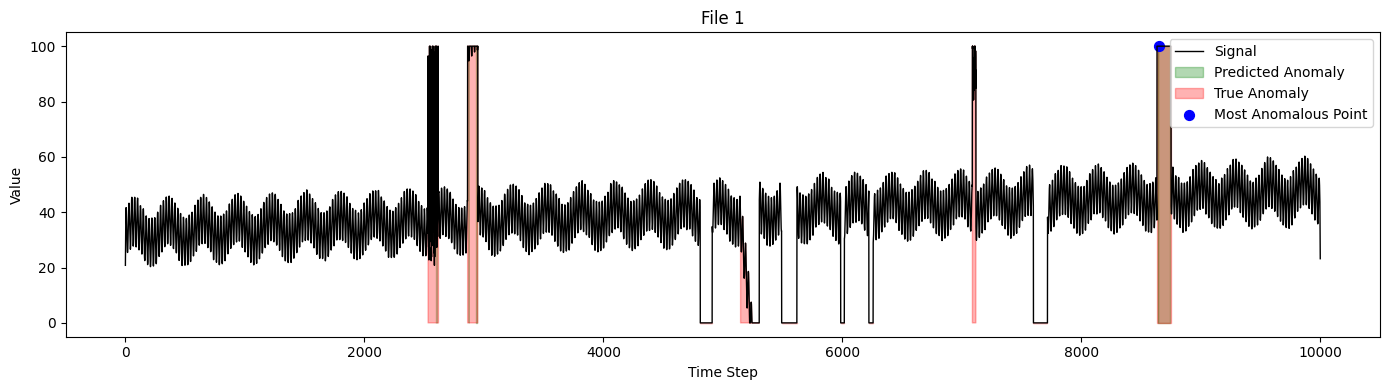

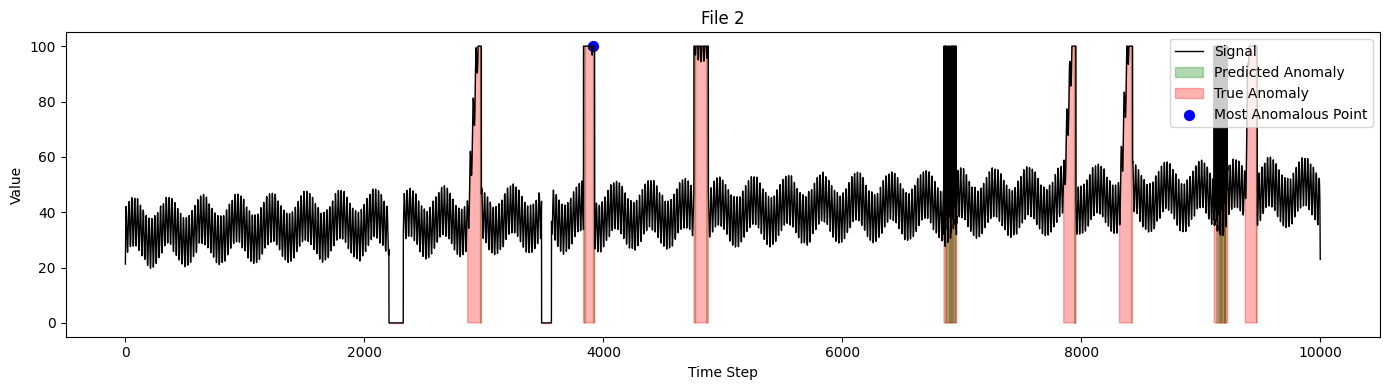

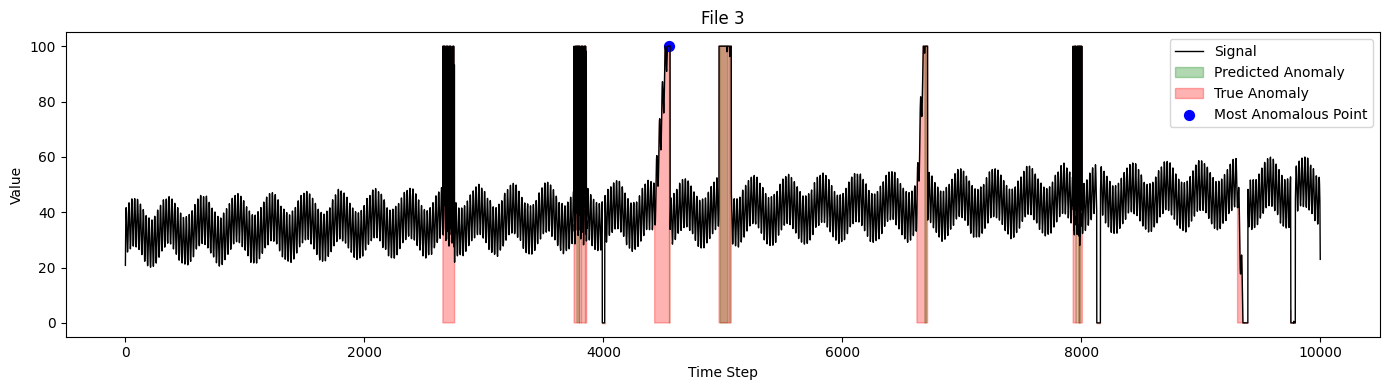

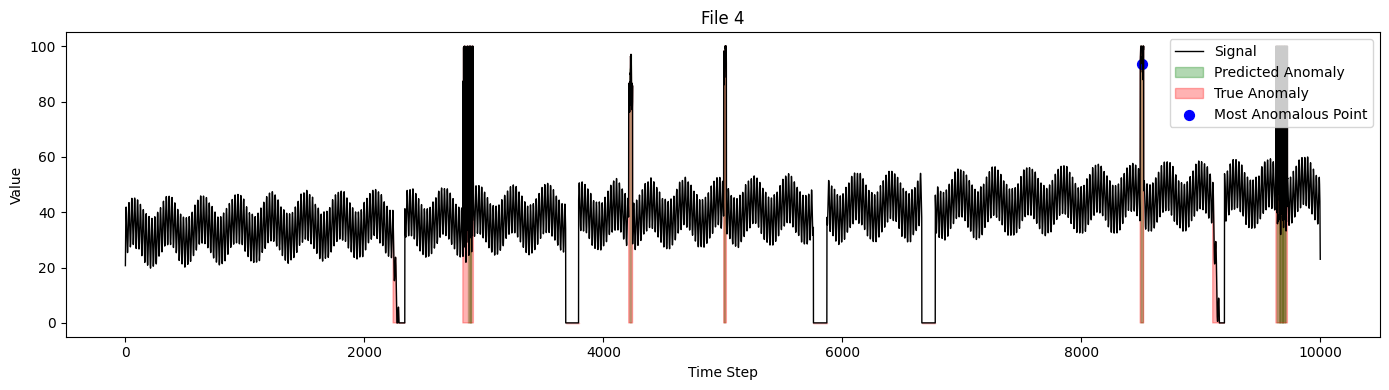

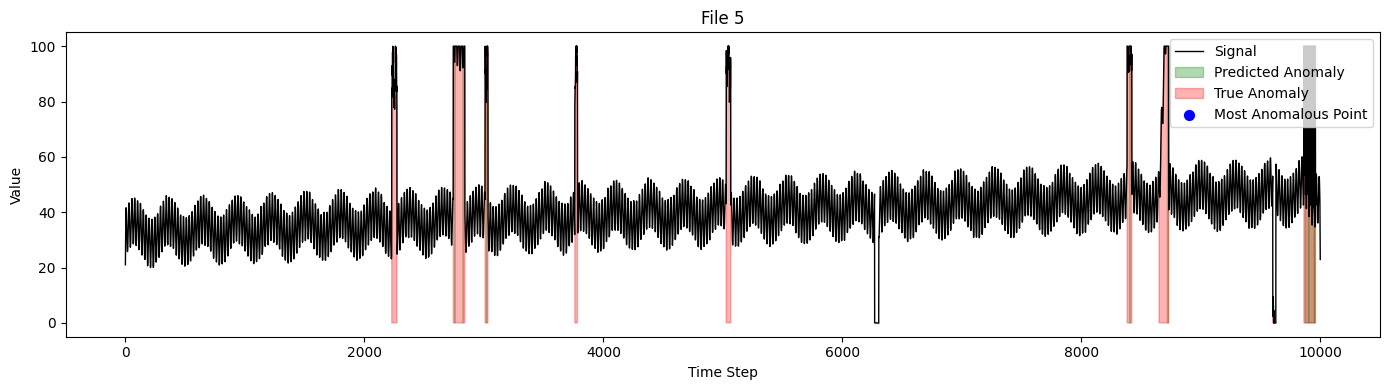

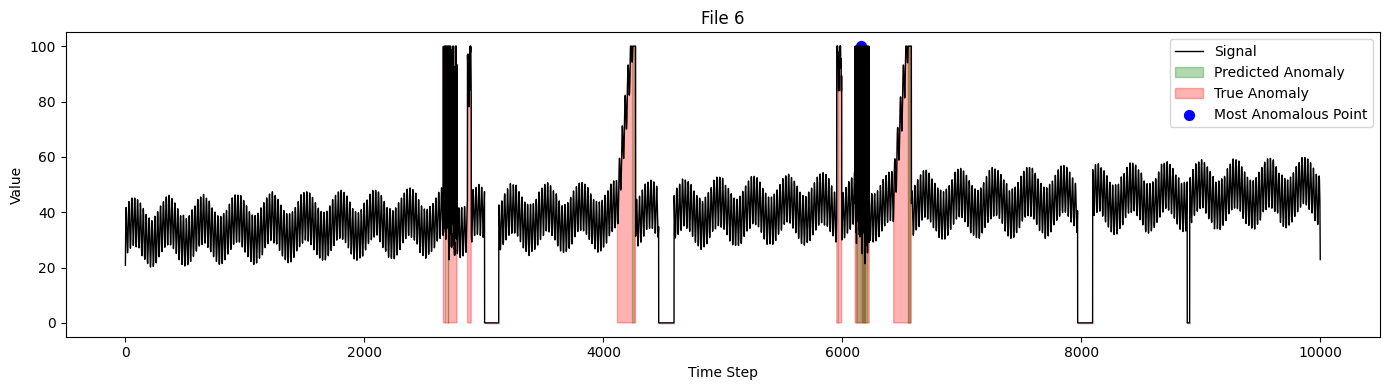

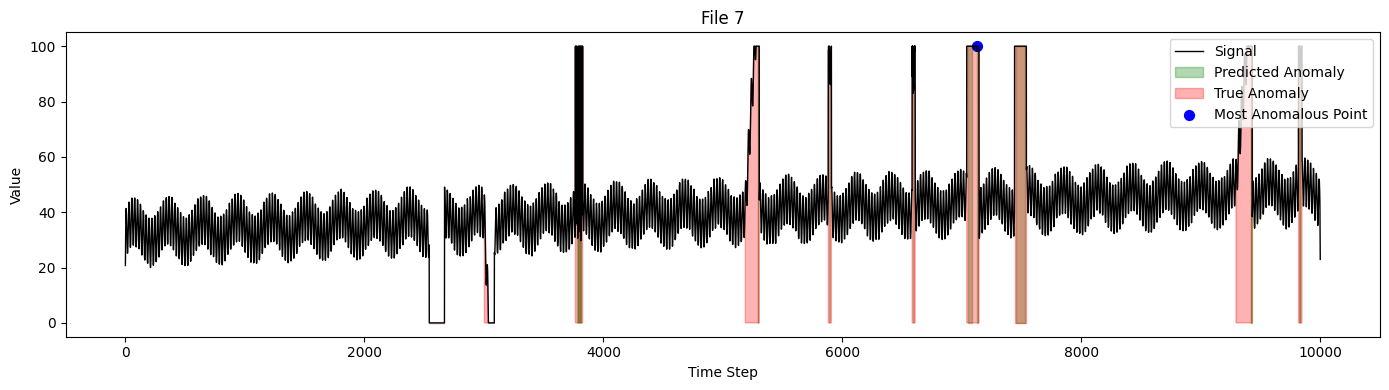

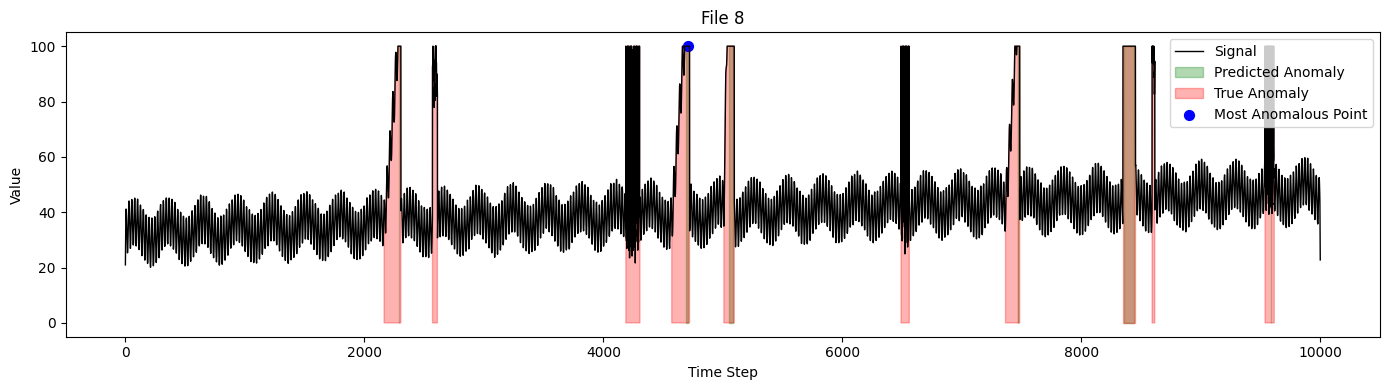

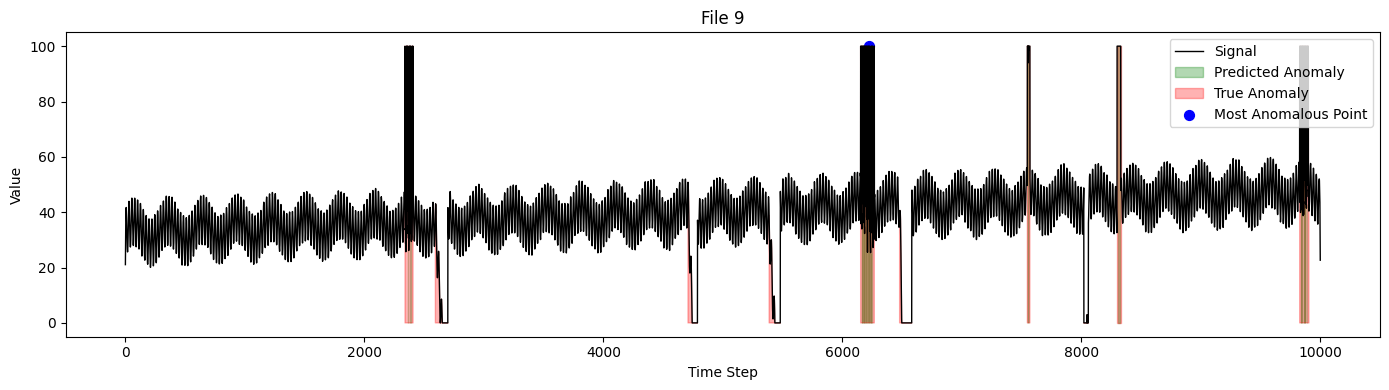

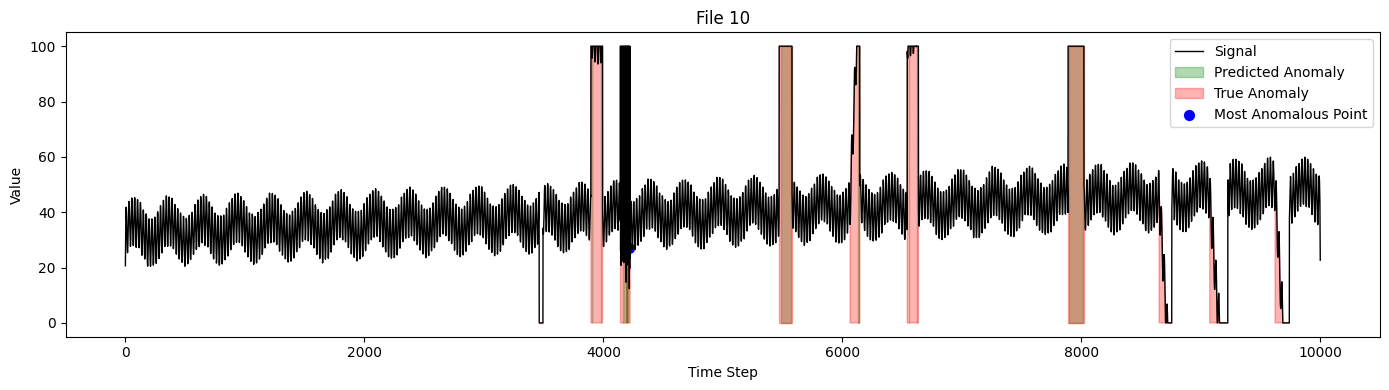

In [ ]:
def visualize_anomaly_detection(test_df, model, file_idx=None):
    """
    Visualizes:
    - Signal (black)
    - Ground truth anomalies (red)
    - Predicted anomalies (green)
    - Most anomalous index (blue dot)
    """
    series = test_df['Value1'].to_numpy()
    true_mask = test_df['Labels'].to_numpy().astype(bool)
    pred_mask = model.full_anomaly_mask.astype(bool)
    most_anomalous = np.argmin(pred_mask) if pred_mask.any() else None
    pred_index = model.predict(series)  # triggers .full_anomaly_mask

    plt.figure(figsize=(14, 4))
    plt.plot(series, color='black', lw=1, label='Signal')

    if pred_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=pred_mask, color='green', alpha=0.3,
                         label='Predicted Anomaly')

    if true_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=true_mask, color='red', alpha=0.3,
                         label='True Anomaly')

    if 0 <= pred_index < len(series):
        plt.scatter(pred_index, series[pred_index], color='blue', s=50, label='Most Anomalous Point')

    title = f"File {file_idx}" if file_idx is not None else "Anomaly Detection"
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# -- Loop over all files and visualize each --
for idx, (train, test) in enumerate(zip(train_files, test_files), 1):
    model = AnomalyDetectionModel(window_size=30, contamination=0.01)
    model.fit(train['Value1'].to_numpy(), train['Labels'].to_numpy())
    model.predict(test['Value1'].to_numpy())  # sets .full_anomaly_mask
    visualize_anomaly_detection(test, model, file_idx=idx)